# Deep Learning for Advanced Object Detection

### Make sure you change the "Runtime" to T4.

### Install Required Packages

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations pandas Pillow requests pydot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for labelme: filename=labelme-5.4.1-py3-none-any.whl size=1436184 sha256=817584efc3b37ba06f049194ddec1b9ad137106eeb9a1eb00127a0aacd9c3c40
  Stored in directory: /root/.cache/pip/wheels

### Import packages

In [2]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import base64

## This notebook uses Existing Images
### Images and Labels are preloaded in this GitHub repo created by the team:

[GitHub Repository](https://github.com/christianingul/deep_learning_for_advanced_facial_recognition)

## Preprocessing

#### Create a Local Directory to store images and labels!

In [3]:
import os

# Base directory for all data
base_directory = '/content/data'

# Subdirectories for different dataset splits
subdirs = ['train', 'val', 'test']

# Loop through each subdir and create 'images' and 'labels' subdirectories within each
for subdir in subdirs:
    # Path for images and labels within each subdir
    image_path = os.path.join(base_directory, subdir, 'images')
    label_path = os.path.join(base_directory, subdir, 'labels')

    # Create directories
    os.makedirs(image_path, exist_ok=True)
    os.makedirs(label_path, exist_ok=True)

    # Print paths to confirm creation
    print(f"Created directory: {image_path}")
    print(f"Created directory: {label_path}")


Created directory: /content/data/train/images
Created directory: /content/data/train/labels
Created directory: /content/data/val/images
Created directory: /content/data/val/labels
Created directory: /content/data/test/images
Created directory: /content/data/test/labels


### Fetch Image and Label URLs from GitHub

In [4]:
def get_github_contents(user, repo, path, branch='main'):
    """
    Fetch the file paths within a directory in a GitHub repo using the GitHub API.
    """
    token = 'add token here'

    #token = os.getenv('GITHUB_TOKEN')
    if not token:
        raise EnvironmentError("GitHub token not found in environment variables.")

    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{path}?ref={branch}"
    headers = {"Authorization": f"token {token}"}

    response = requests.get(api_url, headers=headers)

    if response.status_code == 401:
        raise ValueError("Authorization failed. Check your GitHub token.")
    response.raise_for_status()

    content_list = response.json()

    return [content['download_url'] for content in content_list]

# Initialize the dictionary for storing URLs
dataset_urls = {
    'train': {
        'images': [],
        'labels': []
    },
    'val': {
        'images': [],
        'labels': []
    },
    'test': {
        'images': [],
        'labels': []
    }
}


#### Populate the "dataset_urls" dictionary with the Images and Labels from GitHub!

In [5]:
# Populate the dictionary with URLs from GitHub


####### Load Image URLs

dataset_urls['test']['images'] = get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='test/images'
)


dataset_urls['val']['images'] = get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='val/images'
)

dataset_urls['train']['images'] = get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='train_half/images'
)

dataset_urls['train']['images'] = get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='train_half_2/images'
)


####### Load Label URLs

dataset_urls['train']['labels'] += get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='train_half/labels'
)

dataset_urls['train']['labels'] += get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='train_half_2/labels'
)

dataset_urls['test']['labels'] +=  get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='test/labels'
)


dataset_urls['val']['labels'] = get_github_contents(
    user='christianingul',
    repo='deep_learning_for_advanced_facial_recognition',
    path='val/labels'
)



### Load both Images and Labels into a TensorFlow dataset using the fetched labels

In [6]:
import requests
import os

def download_and_save_file(url, base_dir):
    """Download a file and save it to the specified directory based on its type and the URL structure."""
    file_name = url.split('/')[-1]
    parts = url.split('/')

    # Determine file type based on file extension
    file_type = 'labels' if file_name.endswith('.json') else 'images'

    # Determine subdirectory based on the URL parts
    if 'train_half' in url or 'train_half_2' in url: #When uploading images to GitHub we had to create two folders for training due to GitHub upload limits
        sub_dir = 'train'
    elif 'val' in url:
        sub_dir = 'val'
    elif 'test' in url:
        sub_dir = 'test'
    else:
        raise ValueError("URL does not specify a known dataset split")

    # Full path to save the file
    save_path = os.path.join(base_dir, sub_dir, file_type, file_name)

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Download and save the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {file_name} to {save_path}")
    else:
        print(f"Failed to retrieve {url}")

# Base directory for all data
base_directory = '/content/data'


#### Move Images and Labels to correct directory and sub-directories

In [7]:
# Loop over each dataset split and download both images and labels
for split in dataset_urls:
    for file_type in dataset_urls[split]:
        for url in dataset_urls[split][file_type]:
            download_and_save_file(url, base_directory)


Downloaded 49fb1318-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/49fb1318-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4a557be6-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4a557be6-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4aa705b0-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4aa705b0-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4d3b9ce6-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4d3b9ce6-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4d8d5874-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4d8d5874-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4e34267c-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4e34267c-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4ed73470-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4ed73470-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4f28bc5a-01cf-11ef-b9a4-acde48001122.jpg to /content/data/train/images/4f28bc5a-01cf-11ef-b9a4-acde48001122.jpg
Downloaded 4f79f

### Now let's perfom a sanity check to see if we can load the images

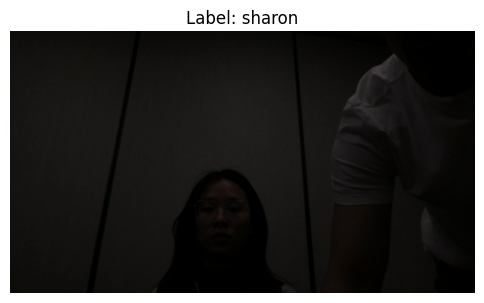

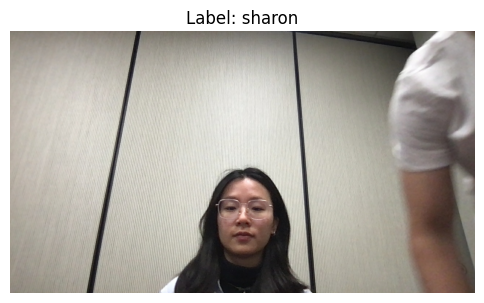

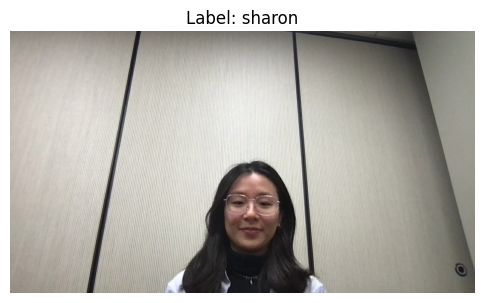

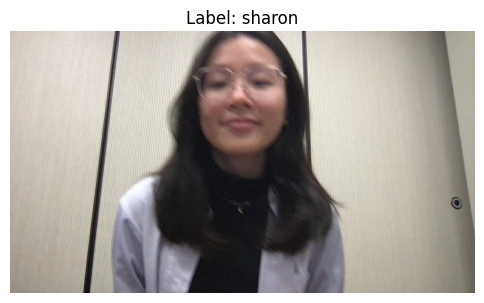

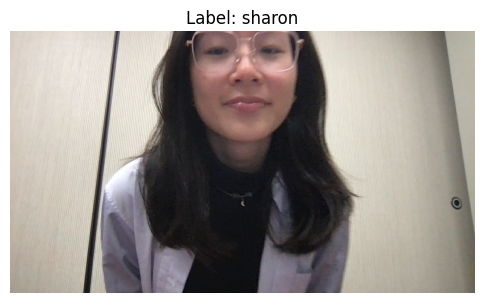

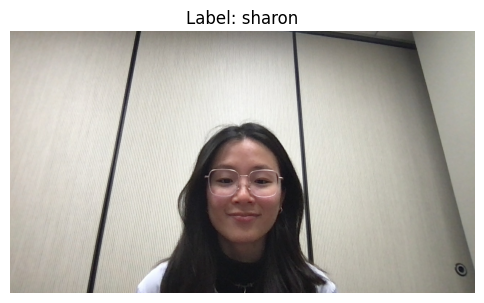

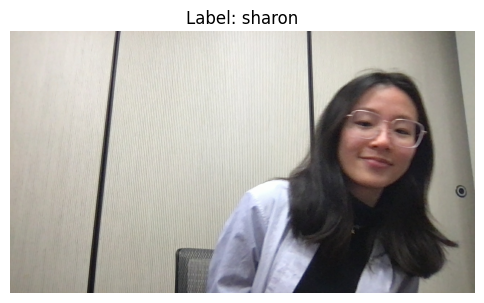

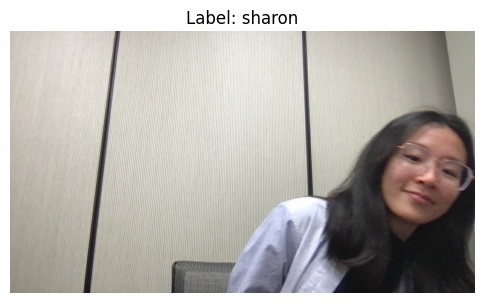

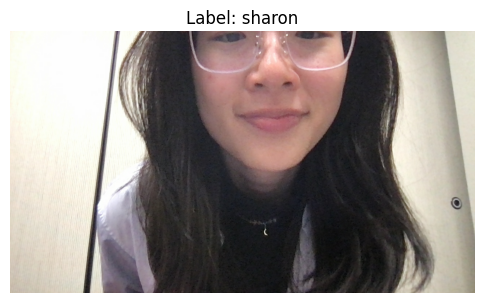

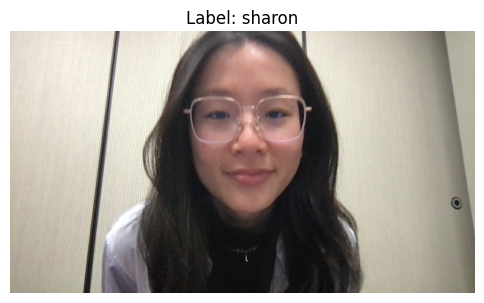

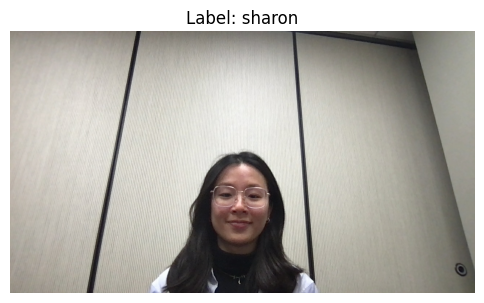

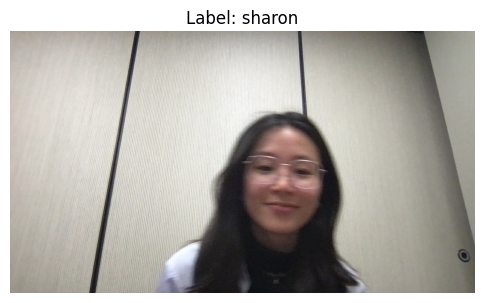

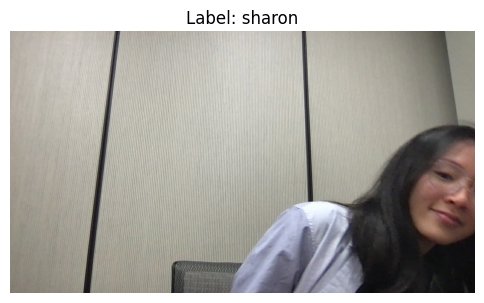

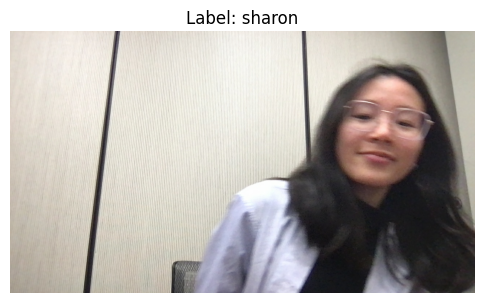

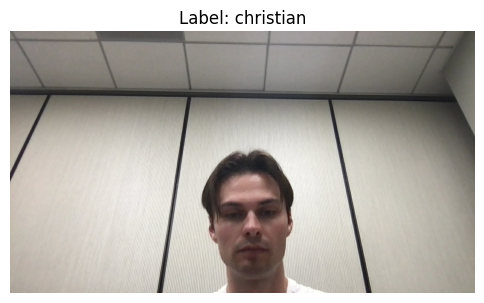

In [8]:
import json

def load_and_display_image_with_label(image_path, label_path):
    """Load and display an image along with its corresponding label."""
    try:
        # Load and decode the image
        byte_img = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(byte_img, channels=3)

        # Load label
        with open(label_path, 'r') as file:
            label = json.load(file)

        # Display image and label
        plt.figure(figsize=(6, 6))
        plt.imshow(image.numpy())
        plt.title(f"Label: {label['shapes'][0]['label']}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to load or display {image_path}: {e}")

# Example usage:
base_directory = '/content/data'
sub_dirs = ['train', 'val', 'test']
num_samples = 5

for sub_dir in sub_dirs:
    image_dir = os.path.join(base_directory, sub_dir, 'images')
    label_dir = os.path.join(base_directory, sub_dir, 'labels')

    images = sorted(os.listdir(image_dir))[:num_samples]
    labels = sorted(os.listdir(label_dir))[:num_samples]

    for image_name, label_name in zip(images, labels):
        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, label_name)
        load_and_display_image_with_label(image_path, label_path)

**Comment:** The labels look correct, awesome!

#### Create a Tensorflow dataset

In [9]:
#Now we need to store the images in a TensorFlow Datafile
import tensorflow as tf

# Create a dataset for training images
all_images = tf.data.Dataset.list_files('/content/data/*/images/*.jpg', shuffle=False)


### Image Augmentation - Using Albumentations
#### Now it is time to augment our images! Run the code below to set up our intended augmentations

In [10]:
#Defining a dictionary, which will later be used to convert names to integers

class_labels = {
    'sharon': 0,
    'adi': 1,
    'christian': 2,
    'none': 3  # Using this for cases with no detected face
}


In [11]:
img_augmentor = alb.Compose([
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## Creating an Augmentation Pipeline

#### Create Directory for Augmented Images

In [12]:
# Base directory for augmented data
base_directory = '/content/aug_data'

# Subdirectories for different dataset splits
subdirs = ['train', 'val', 'test']

# Loop through each subdir and create 'images' and 'labels' subdirectories within each
for subdir in subdirs:
    # Path for images and labels within each subdir
    image_path = os.path.join(base_directory, subdir, 'images')
    label_path = os.path.join(base_directory, subdir, 'labels')

    # Create directories
    os.makedirs(image_path, exist_ok=True)
    os.makedirs(label_path, exist_ok=True)

    # Print paths to confirm creation
    print(f"Created directory: {image_path}")
    print(f"Created directory: {label_path}")


Created directory: /content/aug_data/train/images
Created directory: /content/aug_data/train/labels
Created directory: /content/aug_data/val/images
Created directory: /content/aug_data/val/labels
Created directory: /content/aug_data/test/images
Created directory: /content/aug_data/test/labels


#### Run Image Augmentation Pipeline

In [13]:
#### Takes about 2m to run

for sub_dir in ['train', 'test', 'val']:

    image_folder = os.path.join('/content/data', sub_dir, 'images')

    for image in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, image))
        if img is None:
            continue  # Skip if the image is not loaded properly

        coords = [0, 0, 0.00001, 0.00001]  # Default coordinates

        label_path = os.path.join('/content/data', sub_dir, 'labels', f'{image.split(".")[0]}.json')
        class_label = 3  # Default class for no detected face

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            if label['shapes']:  # Check if there are any annotations
                coords = [label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][0][1],
                          label['shapes'][0]['points'][1][0], label['shapes'][0]['points'][1][1]]
                coords = list(np.divide(coords, [1280, 720, 1280, 720]))  # Normalize coordinates
                class_label = class_labels[label['shapes'][0]['label']]  # Convert string label to integer

        try:
            for x in range(60):  # Augment each image 60 times
                augmented = img_augmentor(image=img, bboxes=[coords], class_labels=[[class_label]])  # Ensure class label is integer
                cv2.imwrite(os.path.join('/content/aug_data', sub_dir, 'images',
                                         f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {'image': f'{image.split(".")[0]}.{x}.jpg'}
                if len(augmented['bboxes']) > 0:
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = augmented['class_labels'][0]  # Ensure correct indexing
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 3  # Use the integer for 'none'

                with open(os.path.join('/content/aug_data', sub_dir, 'labels',
                                       f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


**Comment:** We are now creating 60 augmented images for each original image!

In [14]:
image_path = '/content/aug_data/test/images/4afc6366-01cf-11ef-b9a4-acde48001122.0.jpg'

label_path = '/content/aug_data/test/labels/4afc6366-01cf-11ef-b9a4-acde48001122.0.json'
byte_img = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(byte_img, channels=3)

# Load label
with open(label_path, 'r') as file:
    label = json.load(file)
    print(label)

label_path

{'image': '4afc6366-01cf-11ef-b9a4-acde48001122.0.jpg', 'bbox': [0.42909307065217395, 0.4826388888888888, 0.5641134510869565, 0.8162741545893719], 'class': [0]}


'/content/aug_data/test/labels/4afc6366-01cf-11ef-b9a4-acde48001122.0.json'

### Loading the newly created Augmented Images to our Tensorflow Dataset

### Process the augmented images

In [15]:
def process_image(file_path):

    # Load the JPEG-encoded image from the file path and ensure channels are consistent
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image to the desired size - 224x224 is chose so it matches our MobileNetV2 architecture later in the code!
    image = tf.image.resize(image, [224, 224])

    # Normalize the image to the range [0, 1]
    image = image / 255.0

    # Ensure the shape is strictly enforced, this can help avoid errors in training
    image = tf.ensure_shape(image, (224, 224, 3))

    return image


# Create a Tensorflow dataset of image file paths
all_augmented_images = tf.data.Dataset.list_files('/content/aug_data/*/images/*.jpg', shuffle=False)

# Map the processing function to each item in the dataset, allowing for parallel processing
all_augmented_images = all_augmented_images.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)



### Create datasets for training, validation, and testing

In [16]:
import tensorflow as tf

def load_image(file_path):
    """Load and decode an image from a given file path."""
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

# Create datasets for training, validation, and testing
train_files = tf.data.Dataset.list_files('/content/aug_data/train/images/*.jpg', shuffle=False)
val_files = tf.data.Dataset.list_files('/content/aug_data/val/images/*.jpg', shuffle=False)
test_files = tf.data.Dataset.list_files('/content/aug_data/test/images/*.jpg', shuffle=False)

# Loading images using the map function with parallel calls for efficiency
train_images = train_files.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_images = val_files.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_images = test_files.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


### Creating a Label Loading Function

In [17]:
def load_labels(label_path):
    """Load labels from a file."""
    label_path = label_path.numpy().decode("utf-8")  # Decode the file path from bytes to string

    with open(label_path, 'r') as file:
        label_data = json.load(file)
        class_label = label_data['class']
        bbox = label_data['bbox']

    # Converting the class labels into TensorFlow tensors
    class_label_tensor = tf.convert_to_tensor(class_label, dtype=tf.int32)

    # Converting the bounding box coordinates into TensorFlow tensors
    bbox_tensor = tf.convert_to_tensor(bbox, dtype=tf.float32)

    return class_label_tensor, bbox_tensor

In [18]:
def parse_labels(label_path):
    """Wrap the Python function in a TensorFlow operation."""
    return tf.py_function(load_labels, [label_path], [tf.int32, tf.float32])

In [19]:
def set_shapes(class_label, bbox):
    """Sets the shapes for tensors to ensure compatibility in batch operations."""
    class_label.set_shape([1])  # Ensure there is a single class label per example
    bbox.set_shape([4])  # Ensure each bounding box has four coordinates
    return class_label, bbox


### Loading our Labels to the Tensorflow Dataset

In [20]:
# Create a Tensorflow dataset of our labels data
all_augmented_labels = tf.data.Dataset.list_files('/content/aug_data/*/labels/*.json', shuffle=False)


### Create label datasets for training, validation, and testing

In [21]:
# Define the directories for labels
train_labels_files = tf.data.Dataset.list_files('/content/aug_data/train/labels/*.json', shuffle=False)
val_labels_files = tf.data.Dataset.list_files('/content/aug_data/val/labels/*.json', shuffle=False)
test_labels_files = tf.data.Dataset.list_files('/content/aug_data/test/labels/*.json', shuffle=False)

# Load, parse, and set shapes for the labels
train_labels = train_labels_files.map(parse_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_labels = train_labels.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)


val_labels = val_labels_files.map(parse_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_labels = val_labels.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_labels = test_labels_files.map(parse_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_labels = test_labels.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### Final Tensorflow dataset - Merging Images & Labels

In [22]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)    # Shuffle the data
train = train.batch(10)         # Batch the data
train = train.prefetch(5)      # Prefetch 4 batches at a time to improve pipeline efficiency


In [23]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), (TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [24]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(10)
test = test.prefetch(5)

In [25]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), (TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [26]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(10)
val = val.prefetch(5)

In [27]:
val

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), (TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [28]:
len(train_images),len(train_labels), len(val_images),len(val_labels), len(test_images), len(test_labels)

(2100, 2100, 900, 900, 840, 840)

### Deep Learning Modeling - MobileNetV2


In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


def build_model(input_shape=(224, 224, 3)):
    # Load MobileNetV2 without the top layer and set it to use ImageNet weights
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Set the layers in the base model to be non-trainable (optional)
    for layer in base_model.layers:
        layer.trainable = False  # You can fine-tune this based on your needs

    # Create the feature extractor part
    base_features = GlobalAveragePooling2D()(base_model.output) #Works similar to a flattening layer

    # Add classification and bounding box heads
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(base_features)
    x = Dropout(0.5)(x)
    class_output = Dense(4, activation='softmax', name='class_output')(x)

    y = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(base_features)
    y = Dropout(0.5)(y)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(y)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])
    return model



### Loss Functions - Localization and Classification

In [30]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #Look up reduce_sum again
    #delta coord looks at the first two elements of our bounding box, which is the left side x,y coordinates
    delta_coord_weighted = 1.5 * delta_coord

    #Finding the true height and width
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    #Finding the predicted height and width
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    #Using the values above for our loss
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord_weighted + delta_size

### Display Model Architecture

9406464/9406464 [==============================] - 0s 0us/step


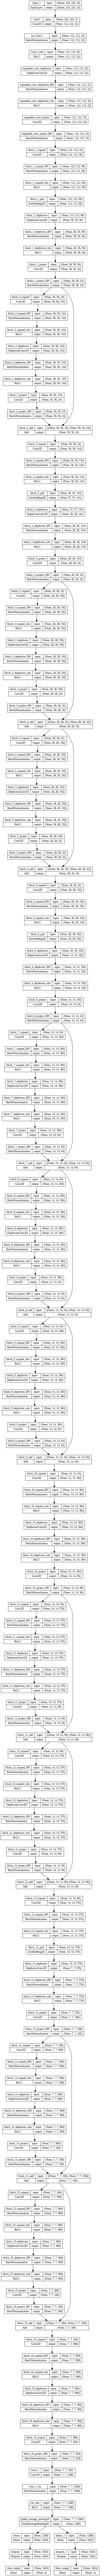

In [31]:
facetracker = build_model()

from keras.utils import plot_model
plot_model(facetracker, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


### Compiling & Training Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# Define the model
facetracker = build_model()

# Compile the model
facetracker.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'class_output': 'sparse_categorical_crossentropy', #class_output, bbox_output
        'bbox_output': localization_loss
    },
    loss_weights={
        'class_output': 1.0,  # Normal weight for classification
        'bbox_output': 1.5   # Increased weight for bounding box regression
    },
    metrics={
        'class_output': ['accuracy'],
        'bbox_output': ['mse']
    })

logdir='logs'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_bbox_output_mse",
        mode='min', #Consider changing to 'min' and monitoring mse
        patience=4
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]



# Train the model
history = facetracker.fit(
    train,
    validation_data=val,
    epochs=40,
    callbacks=callbacks_list  # Add any callbacks like TensorBoard, ModelCheckpoint, etc.
)


Epoch 1/40
 23/210 [==>...........................] - ETA: 28:23 - loss: 28.5717 - class_output_loss: 1.1754 - bbox_output_loss: 3.6908 - class_output_accuracy: 0.4565 - bbox_output_mse: 0.0845

### Evaluate model on the testing set

In [ ]:
test_metrics = facetracker.evaluate(test, verbose=2) #Obviously overfitting.
test_metrics

### Plotting the Model Performance on training and validation data

In [ ]:
import pandas as pd

history = pd.DataFrame(history.history)
history


In [ ]:
# Adjusting the plot based on actual keys and labels
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

# First subplot for overall loss
ax[0].plot(history['loss'], color='teal', label='Training Loss')
ax[0].plot(history['val_loss'], color='orange', label='Validation Loss')
ax[0].set_title('Total Loss (Cross-Entropy + MSE)')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend()

# Second subplot for classification accuracy
ax[1].plot(history['class_output_accuracy'], color='teal', label='Training Classification Accuracy')
ax[1].plot(history['val_class_output_accuracy'], color='orange', label='Validation Classification Accuracy')
ax[1].set_title('Classification Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend()

# Third subplot for regression loss
ax[2].plot(history['bbox_output_mse'], color='teal', label='Training Bbox MSE')
ax[2].plot(history['val_bbox_output_mse'], color='orange', label='Validation Bbox MSE')
ax[2].set_title('Bounding Box MSE')
ax[2].set_xlabel('Number of Epochs')
ax[2].legend()

plt.show()

### Display Bounding Box and Classification on Testing Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
class_names = ['sharon', 'adi', 'christian', 'none']

test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(figsize=(5, 5))  # Single subplot

# Assuming 'test_sample[0]' contains images and 'yhat' contains predictions
# Ensure there is at least one prediction and one test image
if len(test_sample[0]) > 0 and len(yhat[1]) > 0:
    sample_image = test_sample[0][0]  # First image
    sample_coords = yhat[1][0]       # First set of bounding box coordinates
    sample_image = np.array(sample_image).copy()
    class_probs = yhat[0][0]         # First set of class probabilities
    class_id = np.argmax(class_probs)
    max_prob = class_probs[class_id]

    if max_prob > 0.3:  # Change this threshold as needed
        x_min, y_min = np.multiply(sample_coords[:2], [224, 224]).astype(int)
        x_max, y_max = np.multiply(sample_coords[2:], [224, 224]).astype(int)
        cv2.rectangle(sample_image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Optional: Draw label rectangle and text
        label_rect_start = (x_min, y_min - 30)
        label_rect_end = (x_min + 80, y_min)
        #cv2.rectangle(sample_image, label_rect_start, label_rect_end, (255, 0, 0), -1)
        #cv2.putText(sample_image, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    ax.imshow(sample_image)
    ax.set_title('Detected Class: ' + str(class_names[class_id]))
    ax.axis('off')

plt.show()


## Real Time Prediction using OpenCV

In [ ]:
# Initializing the video capture
cap = cv2.VideoCapture(0)

class_names = ['sharon', 'adi', 'christian', 'none']  # List corresponding to the indices

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (224, 224))

    # Predict using the model
    yhat = facetracker.predict(np.expand_dims(resized / 255.0, axis=0))
    sample_coords = yhat[1][0]  # Bounding box predictions - double index converts to column instead of vector
    class_probs = yhat[0][0]    # Class probabilities

    class_id = np.argmax(class_probs) #Returns index of class with the highest probability
    max_prob = class_probs[class_id] #Grabs corresponding probability value

    if max_prob > 0.3 and class_id != 3:  # Check for a significant probability and valid face

        #Rescaling normalized coordinates to match frame size
        x_min, y_min = np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int)
        x_max, y_max = np.multiply(sample_coords[2:], [frame.shape[1], frame.shape[0]]).astype(int)

        # Draw the bounding box
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1) #Controls color of bounding box, 2 size

        # Draw label rectangle and text
        label_text = class_names[class_id]  # Get the class name using the class ID
        label_rect_start = (x_min, y_min - 30) #This sets the starting point of the rectangle 30 pixels above the upper boundary of the bounding box to avoid overlapping with it.
        label_rect_end = (x_min + 80, y_min)#This sets the ending point of the rectangle 80 pixels to the right of the starting point, creating a rectangle width of 80 pixels.
        cv2.rectangle(frame, label_rect_start, label_rect_end, (0, 0, 255), -1)
        cv2.putText(frame, label_text,(x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2) #text is placed slightly above the upper boundary of the bounding box (5 pixels above)

    cv2.imshow('FaceTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
#22 -44